In [1]:
import sys, os, time
# %pdb
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = '/is/ei/fleeb/workspace/chome/trained_nets'
os.environ['FOUNDATION_DATA_DIR'] = '/is/ei/fleeb/workspace/local_data'
# %load_ext autoreload
# %autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim as O
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
import torchvision
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
import gym
import json
import shutil
import inspect
import numpy as np
import h5py as hf
%matplotlib notebook
# %matplotlib tk
import matplotlib.pyplot as plt
import seaborn as sns
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
# from foundation import sim as SIM
#from foundation.util import replicate, Cloner
from scipy import stats
np.set_printoptions(linewidth=120)

In [33]:
B, C, H, W = 5, 6, 16, 16
N = H*W

In [34]:
x = torch.randn(B, C, H, W).view(B, C, N)
x.shape

torch.Size([5, 6, 256])

In [35]:
# x = torch.from_numpy(np.mgrid[-1:1:H*1j, -1:1:W*1j]).unsqueeze(0)
# x.shape

In [36]:
K, V = 7, 4

In [53]:
key, val = torch.randn(K, C), torch.randn(V, K)
key.shape, val.shape

(torch.Size([7, 6]), torch.Size([4, 7]))

In [54]:
w = F.softmax(key.expand(B,*key.shape) @ x, dim=-1)
w.shape

torch.Size([5, 7, 256])

In [55]:
y = val.expand(B, *val.shape) @ w
y.shape

torch.Size([5, 4, 256])

In [41]:
n = nn.Unfold(4,stride=2)

In [42]:
y = n(X)
y.shape

torch.Size([1, 32, 961])

In [44]:
c = y.view(2,16, -1).mean(1)

<IPython.core.display.Javascript object>


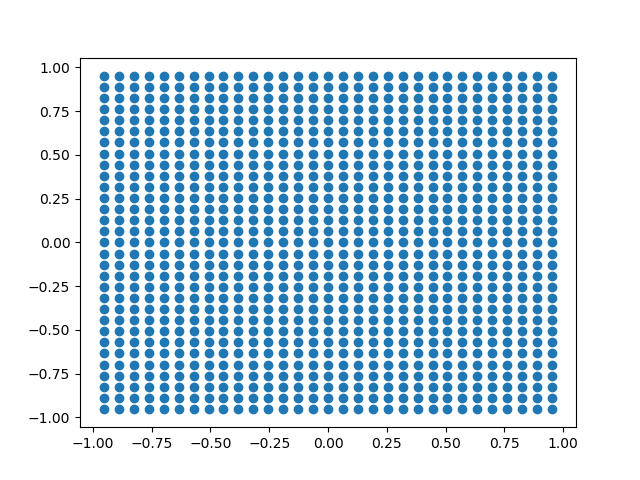

In [55]:
plt.figure()
plt.scatter(*c.numpy())
pass

In [50]:
f = nn.Fold((62,62), 1, stride=1)

In [52]:
k, s = 4, 2
h = (H - (k-1) - 1)//s + 1
w = (W - (k-1) - 1)//s + 1
h,w

(31, 31)

In [158]:
B,G,K,N = 5, 4, 2, 31*31

In [159]:
x = torch.randn(B,G,K,N)
# x = x.cumsum(0)
x = F.softmax(x, dim=-1)
x.shape

torch.Size([5, 4, 2, 961])

In [160]:
h, w = util.calc_tiling(x.size(-1))
h, w

(31, 31)

In [161]:
cmap = cm.get_cmap('seismic')

In [178]:
g = x.sum(0) / B
g = g.view(G,K,h,w)#.permute(0,2,1,3).contiguous().view(G*h,K*w)
g = g.view(G*K,h,w)#*100
g = torch.from_numpy(cmap(g.numpy())).permute(0,3,1,2)
g = torchvision.utils.make_grid(g, nrow=K, padding=1, pad_value=1,
#                                 scale_each=True, normalize=True,
                               )#.norm(p=1, dim=0)
g.shape

torch.Size([4, 129, 65])

<IPython.core.display.Javascript object>


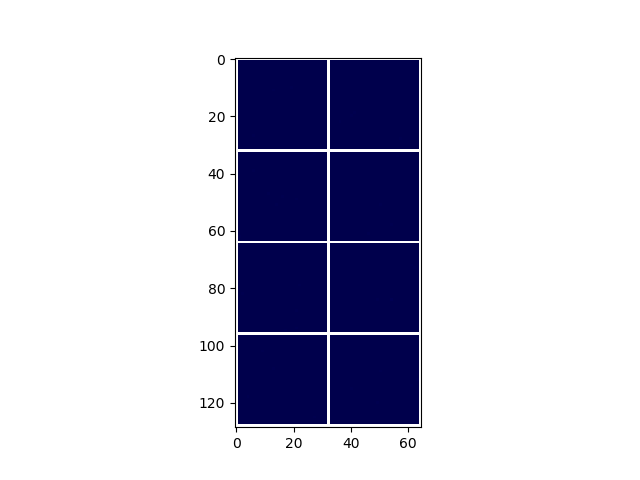

In [179]:
plt.figure()
plt.imshow(g[:3].permute(1,2,0))
# plt.imshow(g)

In [140]:
from matplotlib import cm

In [152]:
x = cm.get_cmap('seismic')(np.random.randn(10000).reshape(100,100))
x.shape

(100, 100, 4)

<IPython.core.display.Javascript object>


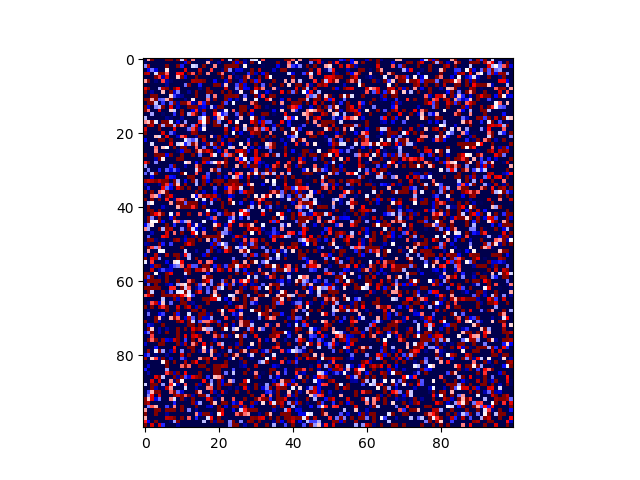

In [153]:
plt.figure()
plt.imshow(x)

In [ ]:
im = np.uint8(cm.gist_earth(myarray)*255)

In [69]:
# plt.figure()
# plt.imshow(g[0,0])

In [31]:
f = nn.Fold((64,64), 4, stride=2)

In [34]:
z = f(F.sigmoid(y))
z.shape

/is/ei/fleeb/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([5, 2, 64, 64])

<IPython.core.display.Javascript object>


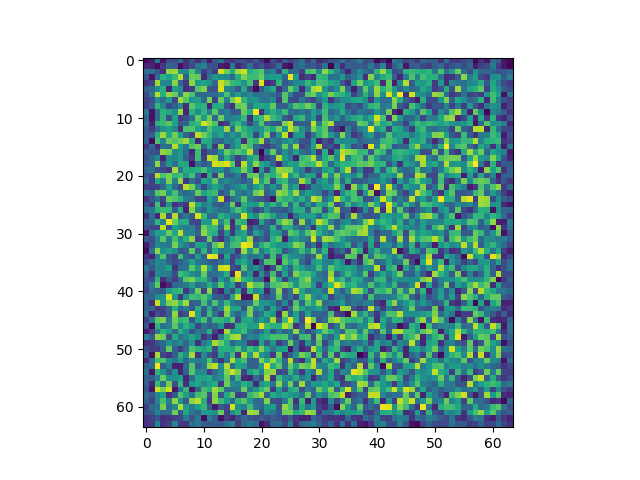

In [56]:
plt.figure()
plt.imshow(z[0,0])

In [17]:
x = torch.randn(C, N)
x.expand(B).shape

RuntimeError: expand(torch.FloatTensor{[4, 8]}, size=[10]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [10]:
x = torch.randn(B,C,N)
x.shape

torch.Size([10, 4, 8])

In [12]:
n = nn.Softmax(dim=-1)

In [13]:
y = n(x)
y.shape

torch.Size([10, 4, 8])

In [14]:
y.view(B,C,-1).sum(-1)

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])

In [2]:
C = trn.get_config()
C

{{'_ipython_canary_method_should_not_exist_':{{}}}}

In [3]:
C.l = [trn.get_config(), trn.get_config()]
C

{{'_ipython_canary_method_should_not_exist_':{{}}, 'l':t[{{}}, {{}}]}}

In [4]:
C['l.0.a.b.1.c'] = 10

In [5]:
'l.0.a.b' in C

True

In [6]:
type(C.l)

foundation.train.config.ConfigList

In [7]:
C['l.0.a']

{{'b':{{'1':{{'c':10}}}}, '_ipython_canary_method_should_not_exist_':{{}}}}

In [8]:
'l.0' in C

True

In [9]:
C

{{'_ipython_canary_method_should_not_exist_':{{}}, 'l':t[{{'a':{{'b':{{'1':{{'c':10}}}}, '_ipython_canary_method_should_not_exist_':{{}}}}}}, {{}}]}}

In [10]:
C.pull('l.0')

  0 (type=dict): 
    (a) (type=dict): 
      (b) (type=dict): 
        (1) (type=dict): 
        (c): 10
      (_ipython_canary_method_should_not_exist_) (type=dict): 


{'a': {'b': {'1': {'c': 10}}, '_ipython_canary_method_should_not_exist_': {}}}

In [12]:
C.l.pull('0')

  0 (type=dict): 
    (a) (type=dict): 
      (b) (type=dict): 
        (1) (type=dict): 
        (c): 10
      (_ipython_canary_method_should_not_exist_) (type=dict): 


{'a': {'b': {'1': {'c': 10}}, '_ipython_canary_method_should_not_exist_': {}}}

In [11]:
C.pull('l')

  l (type=list): 
    [0] (type=dict): 
      (a) (type=dict): 
        (b) (type=dict): 
          (1) (type=dict): 
          (c): 10
        (_ipython_canary_method_should_not_exist_) (type=dict): 
    [1] (type=dict): 


({'a': {'b': {'1': {'c': 10}},
   '_ipython_canary_method_should_not_exist_': {}}},
 {})

In [34]:
C['l.0.a.b']

{{'1':{{'c':10}}, '_ipython_canary_method_should_not_exist_':{{}}}}

In [16]:
x = torch.randn(10,12)

In [24]:
ls = x.split([3,3,3,3], dim=1)
[l.shape for l in ls]

[torch.Size([10, 3]),
 torch.Size([10, 3]),
 torch.Size([10, 3]),
 torch.Size([10, 3])]

In [6]:
C.update()

In [7]:
c = C['l.0.a.b.1']
c

{{'c':10, '_ipython_canary_method_should_not_exist_':{{}}}}

In [9]:
c.pull('l')

l: [{{'a':{{'b':{{'1':{{'c':10, '_ipython_canary_method_should_not_exist_':{{}}}}}}}}}}, {{}}] (in parent)


({{'a':{{'b':{{'1':{{'c':10, '_ipython_canary_method_should_not_exist_':{{}}}}}}}}}},
 {{}})

In [18]:

x[2:] = [1,2]
x

[1, 2, 1, 2]

In [4]:
B, N, D, M = 10, 8, 6, 2

In [5]:
x = torch.randn(B, D, N, N)
x.shape

torch.Size([10, 6, 8, 8])

In [7]:
conv = nn.Unfold(2)

In [8]:
conv(x).shape

torch.Size([10, 24, 49])

In [26]:
B, N, D, M = 10, 8, 6, 2

In [27]:
A = torch.randn(B,D)
S = torch.randn(N,D)

In [34]:
out = F.cosine_similarity(A.unsqueeze(1), S.unsqueeze(0), dim=-1)
out.shape

torch.Size([10, 8])

In [35]:
out

tensor([[ 0.3176,  0.0936, -0.1476, -0.0195,  0.3700, -0.3900,  0.3549,  0.2018],
        [-0.0801,  0.5519,  0.5747, -0.3497,  0.1317,  0.6117, -0.3976, -0.2558],
        [-0.2931, -0.1262, -0.2615,  0.5228, -0.5873, -0.0732,  0.0640,  0.1640],
        [-0.2877, -0.7237, -0.9057, -0.5739, -0.2735, -0.0863, -0.1532,  0.3962],
        [-0.2767, -0.2360,  0.3426, -0.4350,  0.3134,  0.3668, -0.5839, -0.5496],
        [-0.3419,  0.2782, -0.1281, -0.1999, -0.8643,  0.4912, -0.6784,  0.0025],
        [-0.2083, -0.6270, -0.5396,  0.2619, -0.0166, -0.5204,  0.1208,  0.0716],
        [-0.3484,  0.2230,  0.6365,  0.0951,  0.1327,  0.6528, -0.0580, -0.2025],
        [ 0.1961, -0.3887, -0.2771,  0.2593,  0.1913, -0.7912, -0.0784, -0.3118],
        [-0.2186,  0.3331,  0.6389,  0.3429,  0.5625,  0.3629,  0.4653,  0.0203]])

In [41]:
out.sort(0)[0]

tensor([[-0.3484, -0.7237, -0.9057, -0.5739, -0.8643, -0.7912, -0.6784, -0.5496],
        [-0.3419, -0.6270, -0.5396, -0.4350, -0.5873, -0.5204, -0.5839, -0.3118],
        [-0.2931, -0.3887, -0.2771, -0.3497, -0.2735, -0.3900, -0.3976, -0.2558],
        [-0.2877, -0.2360, -0.2615, -0.1999, -0.0166, -0.0863, -0.1532, -0.2025],
        [-0.2767, -0.1262, -0.1476, -0.0195,  0.1317, -0.0732, -0.0784,  0.0025],
        [-0.2186,  0.0936, -0.1281,  0.0951,  0.1327,  0.3629, -0.0580,  0.0203],
        [-0.2083,  0.2230,  0.3426,  0.2593,  0.1913,  0.3668,  0.0640,  0.0716],
        [-0.0801,  0.2782,  0.5747,  0.2619,  0.3134,  0.4912,  0.1208,  0.1640],
        [ 0.1961,  0.3331,  0.6365,  0.3429,  0.3700,  0.6117,  0.3549,  0.2018],
        [ 0.3176,  0.5519,  0.6389,  0.5228,  0.5625,  0.6528,  0.4653,  0.3962]])

In [12]:
x = np.random.randn(4)
x

array([-0.11903327,  1.10899404, -1.12261048, -0.01919107])

In [3]:
b = x.tobytes()
b

b"\x15\xba\xa0\x0b\xd5\xc0\xa6\xbf\xb4T'\xebxM\xf5?\xd7\x91\xfeE\xc66\xd8?\xbew\xa2;O\x9c\x89\xbf"

In [15]:
c = complex(x[0], x[1])
c

(-0.11903326579480775+1.1089940427676077j)

In [17]:
complex(str(c)) == c

True

In [19]:
c.real, c.imag

(-0.11903326579480775, 1.1089940427676077)

In [22]:
class A:
    pass

In [5]:
s = b.decode('latin1')
s

"\x15º\xa0\x0bÕÀ¦¿´T'ëxMõ?×\x91þEÆ6Ø?¾w¢;O\x9c\x89¿"

In [8]:
j = json.dumps(s)
j

'"\\u0015\\u00ba\\u00a0\\u000b\\u00d5\\u00c0\\u00a6\\u00bf\\u00b4T\'\\u00ebxM\\u00f5?\\u00d7\\u0091\\u00feE\\u00c66\\u00d8?\\u00bew\\u00a2;O\\u009c\\u0089\\u00bf"'

In [9]:
js = json.loads(j)
js

"\x15º\xa0\x0bÕÀ¦¿´T'ëxMõ?×\x91þEÆ6Ø?¾w¢;O\x9c\x89¿"

In [10]:
bb = js.encode('latin1')
bb

b"\x15\xba\xa0\x0b\xd5\xc0\xa6\xbf\xb4T'\xebxM\xf5?\xd7\x91\xfeE\xc66\xd8?\xbew\xa2;O\x9c\x89\xbf"

In [11]:
b == bb

True

In [44]:
q = torch.randn(8,6)
steps = 10
bounds = (-2,2)
bounds = None

In [66]:
Q = q.clone()

N, D = Q.shape
S = steps

dH, dW = util.calc_tiling(D)

# bounds = (-2,2)

save_inds = [0, 1, 2, 3]

saved_walks = []

I = torch.eye(D).view(1,1,D,D)

deltas = torch.linspace(0,1,steps=S)
deltas = torch.stack([deltas]*D) # DxS

mn, mx = (Q.min(0)[0].view(D,1), Q.max(0)[0].view(D,1)) if bounds is None else torch.tensor(bounds).view(2,1,1).expand(2, D,1)
# print(mn.shape, mx.shape)

deltas *= mx - mn
deltas += mn
deltas = deltas.t().unsqueeze(0).expand(N,S,D).unsqueeze(-1)

Q = Q.unsqueeze(1).unsqueeze(-1).expand(N,S,D,D)

vecs = Q*(1-I) + deltas*I # NxSxDxD
vecs = vecs.permute(0,1,3,2)


In [67]:
vecs.shape

torch.Size([8, 10, 6, 6])

In [69]:
D = torch.diagonal(vecs, dim1=2, dim2=3)
D.shape

torch.Size([8, 10, 6])

In [70]:
D[0,0]

tensor([-1.3966, -0.8228, -0.8089, -2.5588, -1.9042, -2.5482])

In [63]:
b = 2

q[b]

tensor([-1.3966, -0.0268,  0.3520,  1.5809,  0.1175, -0.4542])

In [65]:
vecs[b,:,1]

tensor([[-1.3966, -0.8228,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966, -0.5782,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966, -0.3337,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966, -0.0891,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  0.1555,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  0.4000,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  0.6446,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  0.8892,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  1.1338,  0.3520,  1.5809,  0.1175, -0.4542],
        [-1.3966,  1.3783,  0.3520,  1.5809,  0.1175, -0.4542]])

In [6]:
x = torch.randint(100, size=(8,8))
x

tensor([[10, 26, 75, 85, 85, 95, 59, 94],
        [58, 60, 42, 15, 83,  0, 39, 23],
        [38, 98,  8, 74, 74,  9, 96, 97],
        [ 7, 54, 31, 83, 63, 83, 91, 63],
        [43, 34, 42, 28, 39, 38, 17,  2],
        [56, 76, 46, 78,  0,  4, 23, 74],
        [24, 92, 35, 74, 93, 19, 30, 87],
        [35, 47, 67, 35, 30, 68, 38, 23]])

In [8]:
x.sort(-1)[0]

tensor([[10, 26, 59, 75, 85, 85, 94, 95],
        [ 0, 15, 23, 39, 42, 58, 60, 83],
        [ 8,  9, 38, 74, 74, 96, 97, 98],
        [ 7, 31, 54, 63, 63, 83, 83, 91],
        [ 2, 17, 28, 34, 38, 39, 42, 43],
        [ 0,  4, 23, 46, 56, 74, 76, 78],
        [19, 24, 30, 35, 74, 87, 92, 93],
        [23, 30, 35, 35, 38, 47, 67, 68]])

In [5]:
dataset = trn.get_dataset('dSprites')
len(dataset)

Loading dataset: dSprites
dataroot: /is/ei/fleeb/workspace/local_data
label_type: None (by default)
din: (1, 64, 64) (by default)
dout: None (by default)
filename: dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz (by default)
Loading dSprites dataset from disk: /is/ei/fleeb/workspace/local_data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz


737280

In [4]:
# sample = dataset[0]

In [2]:
class Test(object):
    def __init__(self, x='no'):
        print('Test', x)
        self.x = x

In [3]:
class D(object):
    def __new__(cls, x='A'):
        print('new-D', x)
        print(cls)
        print(cls.__mro__)
        if x[0] == 'A':
            return super(Test, cls).__new__(Test)
        
    @classmethod
    def _get_type(cls):
        return cls

In [4]:
class M(object):
    def __init__(self, x='test'):
        print('mod', x)
        super().__init__(x='test2')
        
    

In [5]:
C = type('C', (M,D), {})


In [6]:
c = C('hmm')

new-D hmm
<class '__main__.C'>
(<class '__main__.C'>, <class '__main__.M'>, <class '__main__.D'>, <class 'object'>)


In [7]:
A.__name__

NameError: name 'A' is not defined

In [ ]:
A.__name__ = 'B'
A.__name__

In [ ]:
type(A())

In [ ]:
A().__class__.__name__

In [ ]:
C = train.get_config()

In [ ]:
C

In [ ]:
C.a.b.c = 'wow'

In [ ]:
C

In [ ]:
C.begin()
C.another_test = 'huh'
C

In [ ]:
C['how', 'does'] = 134
C

In [ ]:
C.abort()

In [ ]:
C

In [ ]:

len(A)

In [ ]:

len(B)

In [ ]:
cream = 100000
A = set(torch.randperm(500000).tolist()[:cream])
B = set(torch.randperm(500000).tolist()[:cream])

In [ ]:
len(A.intersection(B))

In [ ]:
# import tqdm
from time import sleep

def transfer():
    pbar = tqdm(range(1000), desc="Transfer progress",)# ncols=100, bar_format='{l_bar}{bar}|')
    for i in pbar:
        sleep(np.random.rand()/50)
        if np.random.rand() < 0.01:
            interrupt(pbar)
                # break

def interrupt(pbar):
    pbar.write("File transfer interrupted: {}".format(np.random.randint(10)), end="")

transfer()

In [ ]:
graph = {0:[1,2], 1:[3,4], 2:[4,6], 3:[7], 4:[5], 5:[], 6:[], 7:[]}

In [ ]:
util.toposort(0,lambda x: graph[x], depth_first=True)

In [ ]:
util.set_seed(0)

In [ ]:

print(np.random.randint(10,size=2))
print(util.subset(10,3))
print(np.random.randint(10,size=2))

In [ ]:
torch.arange(10)[util.subset(10,3,2)]

In [ ]:
N = 2

In [ ]:
A = torch.randn(N)
B = torch.randn(N)

In [ ]:
print(A)
print(B)

In [ ]:
def MMD(p, q, C=None):

    if C is None:
        C = q.size(-1)

    ps = util.lorentzian(p, C=C)
    qs = util.lorentzian(q, C=C)
    pq = util.lorentzian(p, q, C=C)

    return ps.mean() + qs.mean() - pq.mean()

In [ ]:
num = 10000
failed = False
for i in tqdm(range(num)):
    A = torch.randn(N)
    B = torch.randn(N)
    a, b = A.unsqueeze(-1),B.unsqueeze(-1)
    
    d = MMD(a,b)
    if d < 0:
        print('Failed: {}'.format(i))
        failed = True
        break
if not failed:
    print('Success')

In [ ]:
A, B

In [ ]:
d

In [ ]:
a, b = A.unsqueeze(-1),B.unsqueeze(-1)

In [ ]:
util.MMD(a,b)

In [ ]:
aa = util.lorentzian(a, C=C)
bb = util.lorentzian(b, C=C)
ab = util.lorentzian(a, b, C=C)

In [ ]:
aa, bb, ab

In [ ]:
aa.mean(), bb.mean()

In [ ]:
ab.mean()

In [ ]:
util.MMD(p, q)

In [ ]:
C = 2

In [ ]:
ps = util.lorentzian(p, C=C)
qs = util.lorentzian(q, C=C)
pq = util.lorentzian(p, q, C=C)

In [ ]:
ps

In [ ]:
qs

In [ ]:
def pairwise_distance(ps, qs=None, p=2): # last dim is summed

    if qs is None:
        return F.pdist(ps, p=p)

    ps, qs = ps.unsqueeze(-2), qs.unsqueeze(-3)
    return (ps - qs).pow(p).sum(-1).pow(1/p)

In [ ]:
def MMD(p, q, C=None):

    if C is None:
        C = q.size(-1)

    ps = util.lorentzian(p, C=C)
    qs = util.lorentzian(q, C=C)
    pq = util.lorentzian(p, q, C=C)

    return ps.view(-1).mean() + qs.view(-1).mean() - 2*pq.view(-1).mean()

In [ ]:
pairwise_distance(q, p)

In [ ]:
pairwise_distance(p, q)

In [ ]:
MMD(p, q)

In [ ]:
ps

In [ ]:
qs

In [ ]:
pq.sum()/4

In [ ]:
pq

In [ ]:
M = nn.Sequential(nn.Linear(10,4), nn.ReLU())
M

In [ ]:
list(M)

In [ ]:
class T(object):
    __name__ = 'A'
    pass

In [ ]:
T.__name__

In [ ]:
t = T()
t.__name__

In [ ]:
type(t).__name__

In [ ]:
t.__class__.__name__

In [ ]:
a = util.NS()
a.b.c.d = 'hello'
print(repr(a)) # --> NS('b':NS('c':NS('d':'hello')))

In [ ]:
a.todict()

In [ ]:
nn.ConvTranspose2d

In [ ]:
conv = nn.Conv2d(8, 8, 2, padding=1)
conv1 = nn.Conv2d(8, 8, 1)
conv2 = nn.Conv2d(8, 8, 2, stride=2)
conv

In [ ]:
X = torch.randn(3, 8, 16, 16)

In [ ]:
I = X
I = conv(I)
I = conv1(I)
I = conv2(I)
Y = I
Y.shape

In [ ]:
X2 = F.interpolate(X, size=(32,32), mode='bilinear')
X2.shape

In [ ]:
conv = nn.ConvTranspose2d(8, 8, 2, stride=2, padding=0, output_padding=0)
conv1 = nn.Conv2d(8, 8, 1)
conv2 = nn.Conv2d(8, 8, 2, stride=1, padding=0)
conv

In [ ]:
X = torch.randn(3, 8, 16, 16)

In [ ]:
I = X
I = conv(I)
# I = conv1(I)
# I = conv2(I)
Y = I
Y.shape

In [ ]:
Y[0,0,-3:,-3:]

In [ ]:
path = os.path.join(os.environ['FOUNDATION_DATA_DIR'], '3dshapes', '3dshapes.h5')
path

In [ ]:
dataset = hf.File(path, 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000

_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

In [ ]:
images.shape, labels.shape

In [ ]:
torch.tensor([0,2,3]).tolist()

In [ ]:
len(images)

In [ ]:
images[torch.tensor([0,2,3]).tolist()].shape

In [ ]:
np.array(torch.randn(3).cuda())

In [ ]:
img = images[0]
img.shape

In [ ]:
img.dtype

In [ ]:
plt.imshow(img)

In [ ]:
root = '/is/ei/fleeb/workspace/chome/trained_nets'
target = '/is/ei/fleeb/workspace/trained_nets/3dshapes_models'
util.create_dir(target)

In [ ]:
from shutil import copyfile

In [ ]:
names = ['checkpoint_100.pth.tar',]# 'best.pth.tar']

In [ ]:
for d in [d for d in os.listdir(root) if '1205' in d]:
    print(d)
    for name in names:
        if name in os.listdir(os.path.join(root, d)):
            print('\t',name)
            if d not in os.listdir(target):
                os.mkdir(os.path.join(target,d))
            copyfile(os.path.join(root, d, name), os.path.join(target, d, name))
            copyfile(os.path.join(root, d, 'config.tml'), os.path.join(target, d, 'config.tml'))

In [ ]:
os.listdir('/is/ei/fleeb/workspace/media/hybrid/new/3dshapes/pres')

In [ ]:
def f(x, *a, **kw):
    print(x, a, kw)

In [ ]:
sig = inspect.signature(f)
sig.parameters

In [ ]:
for n, p in sig.parameters.items():
    pass

In [ ]:
p.kind

In [ ]:
C = util.get_config('base')
C.keys()

In [ ]:
C.device

In [ ]:
C.model

In [ ]:
data = np.load('../local_data/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')
list(data.keys())

In [ ]:
def rec_decode(obj):
    if isinstance(obj, dict):
        return {rec_decode(k):rec_decode(v) for k,v in obj.items()}
    if isinstance(obj, list):
        return [rec_decode(x) for x in obj]
    if isinstance(obj, tuple):
        return tuple(rec_decode(x) for x in obj)
    if isinstance(obj, bytes):
        return obj.decode()
    return obj

In [ ]:
data['latents_values'][:,1:].shape

In [ ]:
meta = rec_decode(data['metadata'][()])
meta.keys()

In [ ]:
meta['date']

In [ ]:
meta['latents_sizes'][1:].sum()

In [ ]:
lbls = data['latents_classes']
lbls.shape

In [ ]:
lbls[10]

In [ ]:
a = (1,2)
b = 3

In [ ]:
*x, y = a
x, y

In [ ]:
a, *b, c = (1,2,3,4)

In [ ]:
b

In [ ]:
images = data['imgs']
images.shape, images.dtype

In [ ]:
images.max(), images.min()

In [ ]:
DS = train.get_dataset('dsprites', dataroot='../local_data/')
len(DS)

In [ ]:
DS.to('cuda')

In [ ]:
new = True

In [ ]:
if new:
    DS = train.get_dataset('mnist', dataroot='../local_data/', train=True, download=False)
    DS.to('cuda')
else:
    DS = torchvision.datasets.MNIST('../local_data/mnist', download=False, train=True, transform=torchvision.transforms.ToTensor())

DS = train.simple_split_dataset(DS, split=0.5, shuffle=False)[0]
    
len(DS)

In [ ]:
DS.indices.device

In [ ]:
loader, = train.get_loaders((DS,), batch_size=512, allow_batched=new)
len(loader)

In [ ]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

In [ ]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

In [ ]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

In [ ]:
%%timeit
for batch in loader:
    X, Y = util.to(batch, 'cuda')
    break

In [ ]:
def moment(x,n=1):
    if n == 1:
        return x.mean()
    m = stats.moment(x,n)
    return np.sign(m)*np.abs(m)**(1/n)

In [ ]:
N = 100000
x = np.random.randn(N)* 1 + 2
y = np.random.randn(N)* 2 + 3

In [ ]:
xy = x*y
ms = [moment(xy,n) for n in range(1,5)]
print(', '.join(['{:2.3f}'.format(m) for m in ms]))

In [ ]:
sns.kdeplot(xy)
# plt.xlim(-4,4)
# plt.ylim(-4,4)

In [ ]:
N, D, M = 8, 4, 2

# class Test(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.A = nn.Linear(D,M)
#         self.B = self.A


X, Y = torch.randn(N,D), torch.randn(N, M)
X.shape, Y.shape

In [ ]:
A = train.get_config()
A

In [ ]:
A.model._type = 'stage'
A.model.stages = [
    train.Config(),
    train.Config(),
]
A.model.stages[0]._type = 'mlp'
A.model.stages[1]._type = 'mlp'
A.model.nonlin = 'elu'
A.model.hidden_dims = [64]

A.din = D
A.dout = M



In [ ]:
M1 = models.make_MLP(D,M, hidden_dims=[8])
M2 = models.make_MLP(D,M, hidden_dims=[])
print(M1)
print(M2)

In [ ]:
M1.training

In [ ]:
optim = util.Complex_Optimizer(M1=util.get_optimizer('adam',M1.parameters()), M2=util.get_optimizer('sgd',M2.parameters()))
optim

In [ ]:
scheduler = O.lr_scheduler.StepLR(optim, 1, gamma=.5)

In [ ]:
print(optim)
scheduler.step()
print(optim)

In [ ]:
for pg in optim.param_groups:
    print(pg.keys())

In [ ]:
list(optim.param_groups)

In [ ]:
optim

In [ ]:
D = 10
Z = torch.zeros(1,D)
X = torch.linspace(-10,10,100).unsqueeze(-1).expand(-1,D)
Z.shape, X.shape

In [ ]:
L = util.lorentzian(X,Z)
L.shape

In [ ]:
plt.figure()
plt.plot(X.squeeze().numpy(), L.squeeze().numpy())

In [ ]:
proc = util.OUNoise(batch_size=4, mu=0., sigma=0.2, theta=.1)

In [ ]:
proc(10).shape

In [ ]:
proc().shape

In [ ]:

N = 100
t = torch.arange(N)
out = proc(N).squeeze()
plt.figure()
plt.plot(t.numpy(), out.squeeze().clamp(-1,1).numpy().T)
plt.plot(t.numpy(), torch.zeros_like(t).numpy(), c='k', ls='--')
plt.ylim(-1.01,1.01)
pass

In [ ]:
import wikipedia

In [ ]:
q1 = wikipedia.page('Machine Learning')
q1

In [ ]:
pgs = wikipedia.random(10)
pgs

In [ ]:
wikipedia.

In [ ]:
q1.links

In [ ]:
pts = torch.randn(10,4)
pts.shape

In [ ]:
sphr = util.cart2sphr(pts)
sphr.shape

In [ ]:
cart = util.sphr2cart(sphr)
cart.shape

In [ ]:
nn.MSELoss()(cart, pts)

In [ ]:
phis = util.cart2angl(pts)
phis

In [ ]:
phis = util.cart2angl(pts*10)
phis

In [ ]:
pts

In [ ]:
sphr

In [ ]:
net = models.make_MLP(10,3,hidden_dims=[20,30,10], nonlin='softplus')
net

In [ ]:
for layer in net[:-1]:
    if isinstance(layer, nn.Linear):
        print(layer)

In [ ]:
sim.sample_action()

In [ ]:
sim.sample_state()

In [ ]:
u = sim.sample_action()
u = torch.ones(1)*0
u

In [ ]:
B = 16
state0 = torch.tensor([0,np.pi,1,0])
state0 = sim.sample_state(B)

In [ ]:
x = sim.reset(state0)

In [ ]:
bb = int(np.sqrt(B))
if bb**2 == B:
    fig, axes = plt.subplots(bb,bb)
else:
    fig, ax = plt.subplots(1)

In [ ]:
for i in range(100):
    u = sim.sample_action(B)
    x = sim.step(u, N=1)
    imgs = sim.render(200,100)
    if len(imgs.shape) == 4:
        for img, ax in zip(imgs, axes.flat):
            ax.cla()
            ax.imshow(img)
            ax.axis('off')
    else:
        ax.cla()
        ax.imshow(imgs)
        ax.axis('off')
    plt.pause(0.03)

In [ ]:
plt.cla()
plt.imshow(sim.render(200,100,index=0 if B is not None else None))
plt.axis('off')
pass

In [ ]:
xs = []
for i in range(100):
    u = sim.sample_action(10)
    x = sim.step(u, N=1)
    xs.append(x)
    plt.cla()
    plt.imshow(sim.render(200,100, index=0 if B is not None else None))
    plt.axis('off')
    plt.pause(0.03)
x

In [ ]:
X = torch.cat(xs)
X.shape

In [ ]:
dataroot = '/is/ei/fleeb/workspace/data'
name = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5'
name = '3dshapes.h5'
name = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
# DS = hf.File(os.path.join(dataroot, name))
DS = np.load(os.path.join(dataroot, name))
len(DS)

In [ ]:
list(DS.keys())

In [ ]:
DS['imgs'].shape

In [ ]:
for k in list(DS.keys()):
    print(k)
    print(k, DS[k].shape)

In [ ]:
DS['latents']['values'][0]

In [ ]:
DS.close()

In [ ]:
torch.eye(10)[torch.randperm(10)]

In [ ]:
B, D, M = 8, 4, 2

# class Test(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.A = nn.Linear(D,M)
#         self.B = self.A


X, Y = torch.randn(B,D), torch.randn(B, M)
X.shape, Y.shape

In [ ]:
model = models.make_MLP(D,M,hidden_dims=[64,64,64,64, 64, 64])
model

In [ ]:
layers = [layer for layer in model if isinstance(layer, nn.Linear)][:-1]
layers

In [ ]:
dX = X+torch.randn_like(X)

In [ ]:
fmatch = models.Feature_Match(layers, model=model)
with torch.no_grad():
    loss = fmatch(X,dX)
loss

In [ ]:
fmatch = models.Feature_Match(model, model=model)
with torch.no_grad():
    loss = fmatch(X,dX)
loss

In [ ]:
model.A.weight.data[0,0] += 1
model.A.weight, model.B.weight

In [ ]:
model.load_state_dict(model.state_dict())

In [ ]:
p = nn.utils.parameters_to_vector(model.parameters())

In [ ]:
loss = nn.MSELoss()(model(X), Y)
loss

In [ ]:
model.zero_grad()
loss.backward()

In [ ]:
for param in model.parameters():
    print(param.grad)

In [ ]:
outputs = []
def keep(m, x, y):
    outputs.append(y)

In [ ]:
model = torchvision.models.squeezenet1_0(pretrained=True, progress=True).cuda()
# model.features.register_forward_hook(keep)
print(model)

In [ ]:
x = torch.rand(4,3,128,128).cuda()
x.shape

In [ ]:
y = model(x)
y.shape

In [ ]:
outputs[0].shape

In [ ]:
info = torch.load('rl/temp_xy.pth.tar')
info.keys()

In [ ]:
X, Y = info['x'], info['y']
X.shape, Y.shape

In [ ]:
mn, mo = info['m_new'], info['m_old']
print(list(mn.parameters()))
print(list(mo.parameters()))

In [ ]:
info['l_old'], info['l_new']

In [ ]:
N,M,D = 20, 5, 3
with torch.no_grad():
    A = torch.randn(N,M)
    f = nn.Linear(M,D)
    b = f(A)
    m = nn.Linear(M,D)

In [ ]:
F.mse_loss(m(A), b)

In [ ]:
util.solve(A,b,out=m)

In [ ]:
F.mse_loss(m(A), b)

In [ ]:
shapes, settings = nets.plan_deconv(out_shape=(3,160,120), channels=[8, 16, 32, 64], kernels=4, strides=2)
shapes

In [ ]:
ms = nn.ModuleList([nn.ConvTranspose2d(**s) for s in settings])
ms

In [ ]:
X = torch.randn(1, *shapes[0])

In [ ]:
x = X
print(x.size())
for m in ms:
    x = m(x)
    print(x.size())

In [ ]:
print(x.shape)
print(m)

In [ ]:
shapes, settings = nets.plan_conv((3,160,120), channels=[8, 16, 32, 64], kernels=3, strides=1, factors=2)
shapes

In [ ]:
ms = nn.ModuleList([nn.Conv2d(**s) for s in settings])
ms

In [ ]:
X = torch.randn(1, *shapes[0])

In [ ]:
x = X
print(x.size())
for m in ms:
    x = m(x)
    print(x.size())

In [ ]:
ms = nn.ModuleList([nn.Conv2d(**s) for s in settings])

In [ ]:
class OU_Process:
    def __init__(self, K=3, std=0.5, theta=0.5):
        self.K = K
        self.std = std
        self.theta = theta
        
        self.x = torch.randn(K) * self.std
        
    def __call__(self, t, state):
        return self.theta * self.x + torch.randn(self.K) * self.std
    
def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

In [ ]:
#env.alpha = 5.
#env.beta = 5.
#env.gamma = 0.1

In [ ]:
env.reset()#(-torch.ones(2)*np.pi/2, torch.zeros(2))
#policy = OU_Process(K=env.N, std=0.5, theta=0.7)
policy = lambda t, x: torch.rand(env.spec.action_space.size)*2 - 1
plt.ioff()

In [ ]:
rgb, lbl = env.render(label=True)
rgb.shape, lbl.shape

In [ ]:
env.obs

In [ ]:
plt.ion()
plt.figure()
plt.imshow(rgb, interpolation='none')

plt.figure()
plt.imshow(lbl, interpolation='none')

In [ ]:
plt.ion()
figax = plt.subplots(figsize=(3,3))
fig, ax = figax
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
for t in range(1000):
    
    action = policy(t, None) #+ 1
    env.step(action)
    
    ax.set_title('{:.3f} {:.3f}'.format(action[0].item(), action[1].item()))
    
    env.render('onscreen', figax=figax)
    plt.pause(0.002)
    ax.cla()
    #break

In [ ]:
plt.show()

In [ ]:
rgb = fig2data(fig)
rgb.shape

In [ ]:
plt.figure()
#plt.axis('off')
plt.imshow(env.render('rgb'))
plt.show()

In [ ]:
env.get_ctrl_freq()